##**Objective :** Build a forecast to determine how many number of passengers are going to abort these airlines at the month level in the future

## **Procedure:**
The general process for ARIMA models is the following:

* Visualize the Time Series Data
* Make the time series data stationary
* Do the required transformations.
* Plot the Correlation and AutoCorrelation Charts for P and Q lags
* Construct the ARIMA Model based on the data.
* Use the model to make predictions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Loading data
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Time Series Modelling/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.shape

(144, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
#data['Month'] = pd.to_datetime(data['Month'], format = '%Y-%m')
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
# Set index as months columns
data = data.set_index(['Month'])
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Visualizing the Data

Text(0, 0.5, 'Number of air Passengers')

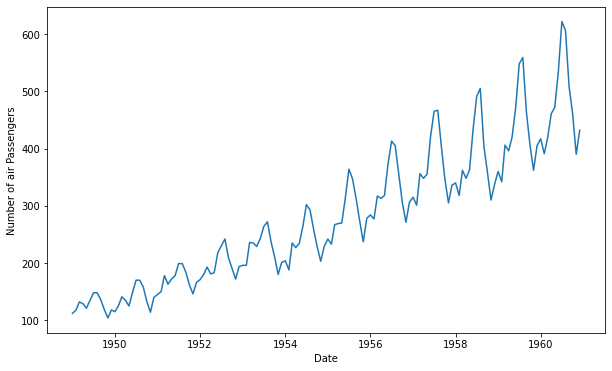

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(data['#Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of air Passengers')

**Observations:**
* This shows that our data has a upward trend.

Now we have to check whether the data is stationay or not. It is very clear from the above plot that mean value is not constant. Therefore the data is not stationary.



* ## Let's check whetther the data is stationary or not not.
1. Rolling statictic method

In [ ]:
# determinig rolling mean
# Here window = 12 means that calulating mean over 12 months. Since our forecast based on the monthly level.
rolmean = data.rolling(window = 12).mean()

# determing rolling standard deviation
rolstd = data.rolling(window=12).std()
print(rolmean, rolstd)


            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


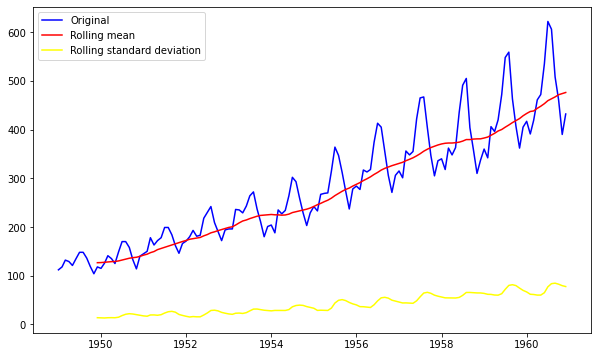

In [ ]:
# plot rolling statistics
plt.figure(figsize=(10,6))
plt.plot(data,color = 'blue', label = 'Original')
plt.plot(rolmean, color = 'red', label = 'Rolling mean')
plt.plot(rolstd, color = 'yellow', label = 'Rolling standard deviation')
plt.legend(loc='upper left')
plt.show()

Observations:
* Since red line is increasing, so we can conclude that rolling mean is not constant.
* Yellow line graph is also increasing, therefore the rolling standard deviation is also not constant.
* From the above two points we can conclude that the data is not stationary.

* ## Now let's check whether the data is stationary or not by
2. ADCF( Augmented dickey fuller test)

In [ ]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller Test:')
dfTest = adfuller(data['#Passengers'], autolag = 'AIC')

dfOutput = pd.Series(dfTest[0:4], index = ['Test Statistic', 'p_value','#lags_used', '#observation used'])
for key, value in dfTest[4].items():
  dfOutput['Critical Values (%s)'%key] = value

print(dfOutput)

if dfOutput['p_value'] < 0.05:
  print('Data is Stationary')
else:
  print('Data is non stationary')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey Fuller Test:
Test Statistic             0.815369
p_value                    0.991880
#lags_used                13.000000
#observation used        130.000000
Critical Values (1%)      -3.481682
Critical Values (5%)      -2.884042
Critical Values (10%)     -2.578770
dtype: float64
Data is non stationary


### **Observations:**
* Since out null hypothesis is Data is non stationary.
* We knoe that if p_value < 0.05 we are going to reject null hypothesis.
* Our p_value is 0.9918 which is greater than 0.05. therefore we reject the null hypothesis.
* For data to be stationary p_value < 0.05 and Test statistics will be very close to critical value.  Hence the data is non stationary.

Now we came to a conclusion that our data is not stationary. Now we will estimating the trend.

## **Transformations**

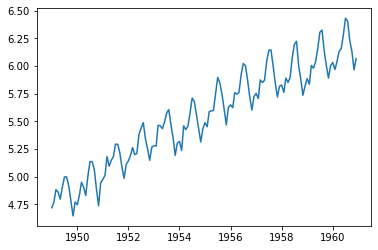

In [ ]:
log_data = np.log(data)
plt.plot(log_data)

* The scale of y-axis has been changed but the trend remains the same.

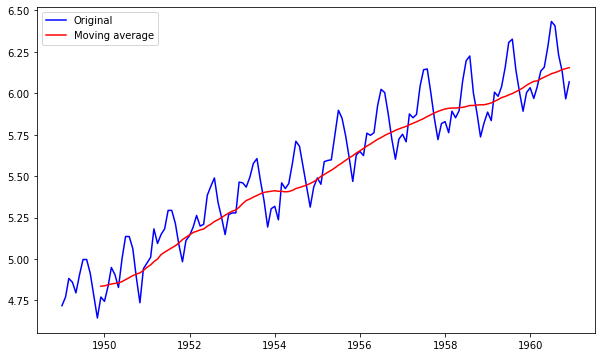

In [ ]:
movingaverage = log_data.rolling(window = 12).mean()
movingstd = log_data.rolling(window=12).std()
# Plot
plt.figure(figsize=(10,6))
plt.plot(log_data, color = 'blue', label = 'Original')
plt.plot(movingaverage, color = 'red', label ='Moving average')
#plt.plot(movingstd, color = 'yellow', label ='Moving Standard deviation')
plt.legend(loc ='best')
plt.show()



To make the data stationary subtract the moving average

In [ ]:
logdataMinusMovingAverage = log_data - movingaverage

# Remove Nan values
logdataMinusMovingAverage.dropna(inplace = True)
logdataMinusMovingAverage.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Now let's check the stationarity

In [ ]:
def testStationarity(timeseries):
  # determining rolling statistics
  movingaverage = timeseries.rolling(window = 12).mean()
  movingstd = timeseries.rolling(window = 12).std()

  # plotting rolling statistics
  plt.figure(figsize = (10,6))
  plt.plot(timeseries, color = 'blue', label = 'Original')
  plt.plot(movingaverage, color = 'red', label = 'Moving Average')
  plt.plot(movingstd, color = 'yellow', label = 'Moving Standard Deviation')
  plt.legend(loc = 'best')
  plt.show()

  # ADCF test
  print('\n Results of Dickey Fuller Test:')
  dfTest = adfuller(timeseries['#Passengers'], autolag = 'AIC')

  dfOutput = pd.Series(dfTest[0:4], index = ['Test Statistic', 'p_value','#lags_used', '#observation used'])
  for key, value in dfTest[4].items():
    dfOutput['Critical Values (%s)'%key] = value

  print(dfOutput)


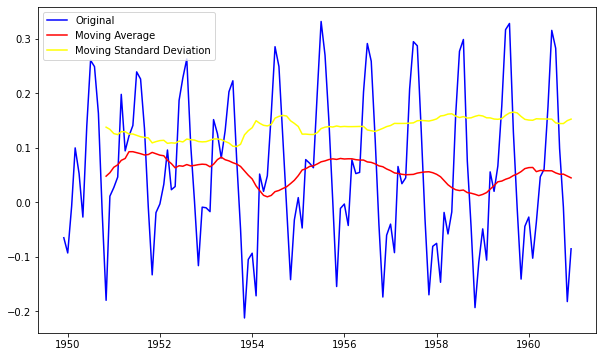


 Results of Dickey Fuller Test:
Test Statistic            -3.162908
p_value                    0.022235
#lags_used                13.000000
#observation used        119.000000
Critical Values (1%)      -3.486535
Critical Values (5%)      -2.886151
Critical Values (10%)     -2.579896
dtype: float64


In [ ]:
testStationarity(logdataMinusMovingAverage)

### **Observations:**
* From the above plot it is very clear that is stationary and it has constant mean and constant standard deviation.
* From the results of ADCF test p_value < 0.05 and test statistics and critical values are approximately same. Therefore we can conclude that now data become stationary.

* Let's now calculate the exponential weighted average.


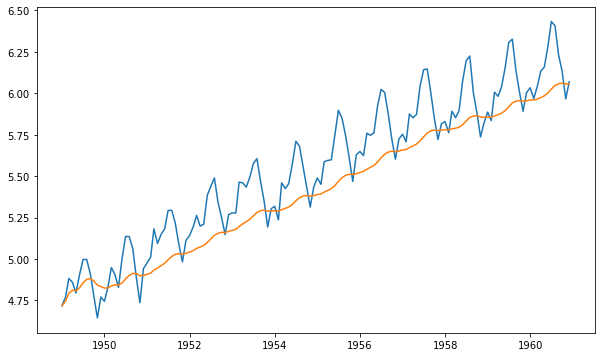

In [ ]:
expodecayWeightaverage = log_data.ewm(halflife = 12, min_periods=0 ,adjust = True).mean()
plt.figure(figsize = (10,6))
plt.plot(log_data)
plt.plot(expodecayWeightaverage)

### **Observations:**
As the timeseries or data increases the exponential weighted average also increases. It shows the upward trend and hence the data is non stationary.

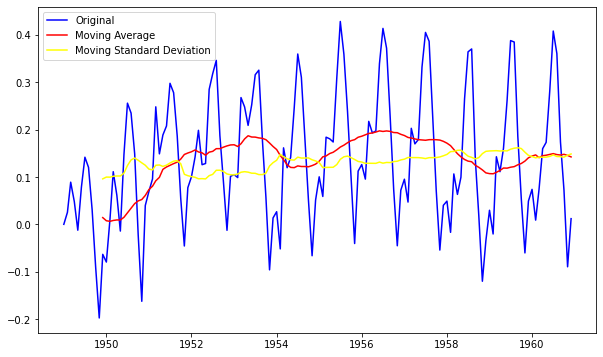


 Results of Dickey Fuller Test:
Test Statistic            -3.601262
p_value                    0.005737
#lags_used                13.000000
#observation used        130.000000
Critical Values (1%)      -3.481682
Critical Values (5%)      -2.884042
Critical Values (10%)     -2.578770
dtype: float64


In [ ]:
log_dataMinusExpoWeightAvg = log_data - expodecayWeightaverage
testStationarity(log_dataMinusExpoWeightAvg)

Now let's shift the values in the time series, so we an use it in forecasting.


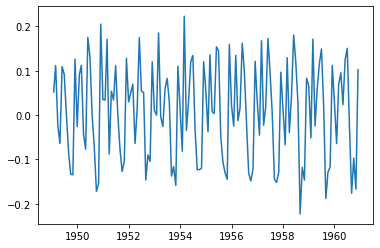

In [ ]:
log_data_diffshift = log_data - log_data.shift()
plt.plot(log_data_diffshift)

Here we have differentiate our time series ones, that is take a lag of one. So now the values of d = 1(order of differentiation)

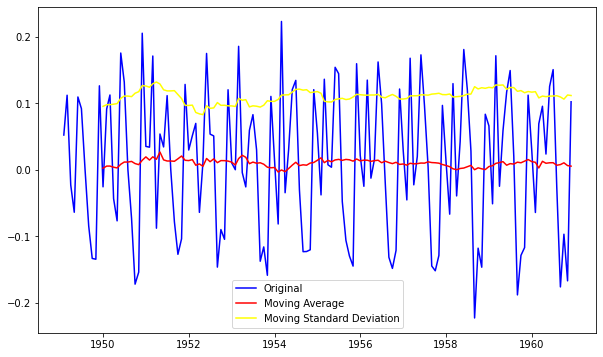


 Results of Dickey Fuller Test:
Test Statistic            -2.717131
p_value                    0.071121
#lags_used                14.000000
#observation used        128.000000
Critical Values (1%)      -3.482501
Critical Values (5%)      -2.884398
Critical Values (10%)     -2.578960
dtype: float64


In [ ]:
log_data_diffshift.dropna(inplace = True)
testStationarity(log_data_diffshift)

Observation:
 Now here our data is stationary.

##Components of Time series
Now lets see the components of time series.

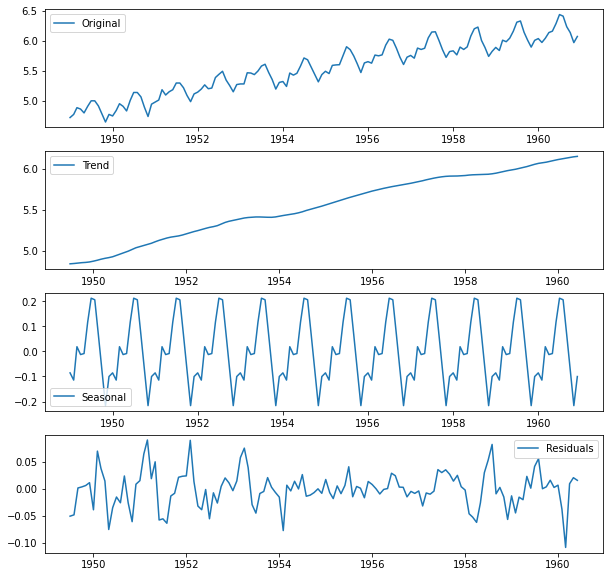

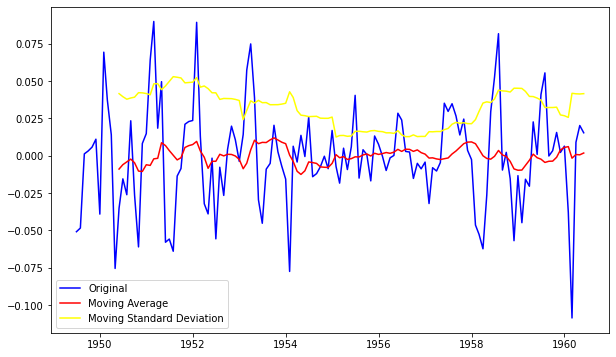


 Results of Dickey Fuller Test:
Test Statistic          -6.332387e+00
p_value                  2.885059e-08
#lags_used               9.000000e+00
#observation used        1.220000e+02
Critical Values (1%)    -3.485122e+00
Critical Values (5%)    -2.885538e+00
Critical Values (10%)   -2.579569e+00
dtype: float64


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_data)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize = (10,10))
plt.subplot(411)
plt.plot(log_data, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')

plt.show()

decomposed_log_data = residual
decomposed_log_data.dropna(inplace = True)
testStationarity(decomposed_log_data)

## Plotting acf and pacf for calculating p and q lags

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

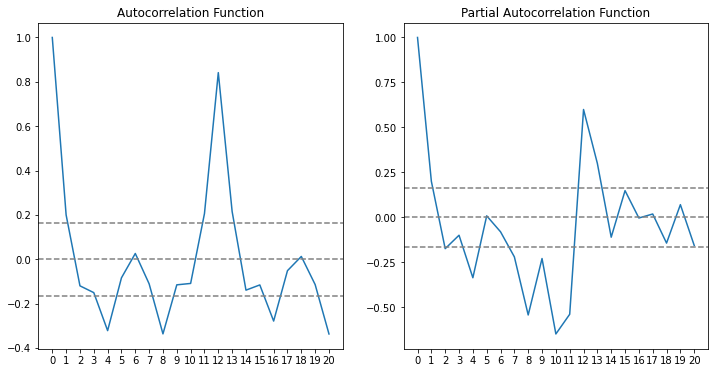

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_data_diffshift, nlags = 20)
lag_pacf = pacf(log_data_diffshift, nlags= 20, method = 'ols')

plt.figure(figsize =(12,6))
#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y= -1.96/np.sqrt(len(log_data_diffshift)), linestyle = '--', color = 'gray')
plt.axhline(y= 1.96/np.sqrt(len(log_data_diffshift)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,21,1))
plt.title('Autocorrelation Function')

#plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y= -1.96/np.sqrt(len(log_data_diffshift)), linestyle = '--', color = 'gray')
plt.axhline(y= 1.96/np.sqrt(len(log_data_diffshift)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,21,1))
plt.title('Partial Autocorrelation Function')

* In order to calculate the P and Q value we need to check out what is value when the graphs drops to zero for the first time. So the value of P and Q are 2 because the graph drops to zero for the first time at 2.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

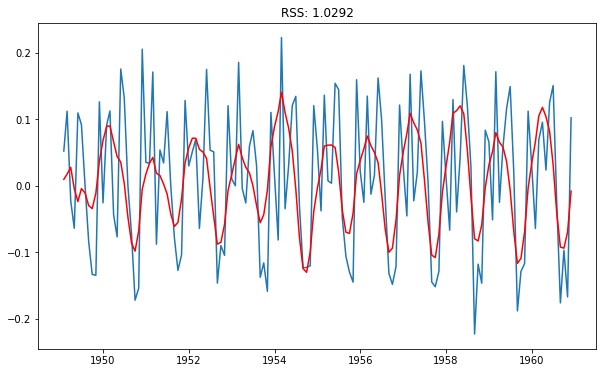

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_data, order = (2,1,2))
results_AR = model.fit(disp =-1)
plt.figure(figsize = (10,6))
plt.plot(log_data_diffshift)
plt.plot(results_AR.fittedvalues, color ='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-log_data_diffshift['#Passengers'])**2))

### **Observations:** 
The RSS(Residual Sum of Square) is value close to 1. It means our model is performing well. Greater will be the RSS, bad our model is.

##Moving Average model- A ARIMA model with having Autoregressive part = 0 that is value of P=0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

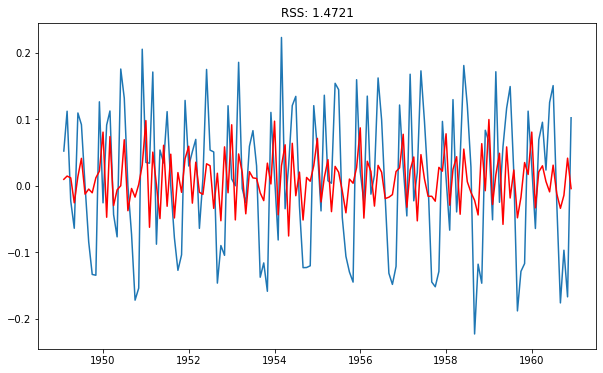

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_data, order = (0,1,2))
results_AR = model.fit(disp =-1)
plt.figure(figsize = (10,6))
plt.plot(log_data_diffshift)
plt.plot(results_AR.fittedvalues, color ='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-log_data_diffshift['#Passengers'])**2))

###Auto Regressive Model- A model with not moving average part. that is value of Q = 0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

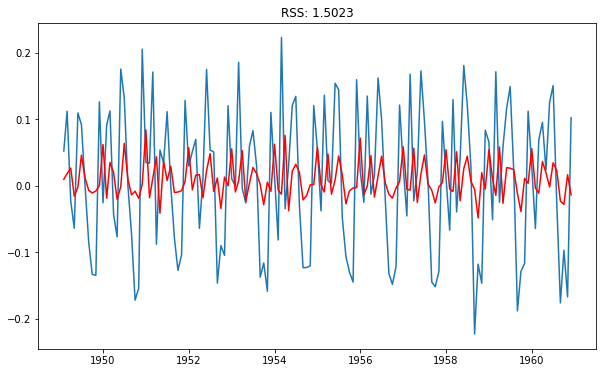

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_data, order = (2,1,0))
results_AR = model.fit(disp =-1)
plt.figure(figsize = (10,6))
plt.plot(log_data_diffshift)
plt.plot(results_AR.fittedvalues, color ='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-log_data_diffshift['#Passengers'])**2))

Observations:
* The RSS score w.r.t AR model is 1.5023 and w.r.t MA model is 1.4721. Therefore combine both of them to get better model with good performance.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

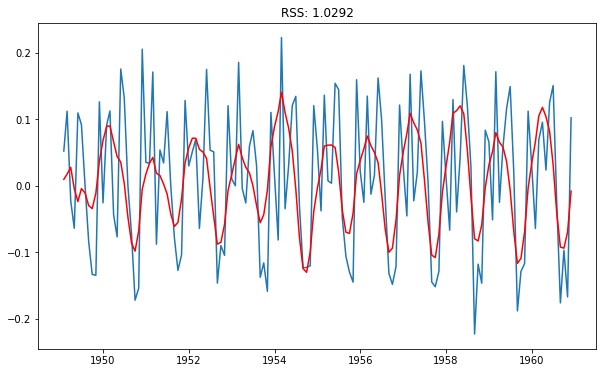

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_data, order = (2,1,2))
results_AR = model.fit(disp =-1)
plt.figure(figsize = (10,6))
plt.plot(log_data_diffshift)
plt.plot(results_AR.fittedvalues, color ='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-log_data_diffshift['#Passengers'])**2))

## **Making Predictions**

In [ ]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy = True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [ ]:
#convert ot cummulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(log_data['#Passengers'], index = log_data.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value = 0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.780265
1949-03-01    4.909873
1949-04-01    4.914554
1949-05-01    4.846011
dtype: float64

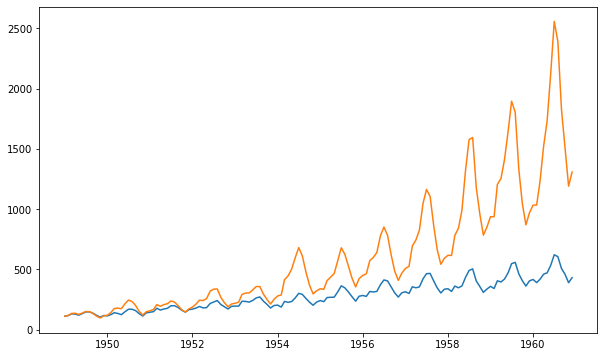

In [ ]:
#Converting in the original form
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize = (10,6))
plt.plot(data)
plt.plot(predictions_ARIMA)

#Now let's predict the future values.
Let's make a predctiction for 10 years. Initially we have 144 rows and now for 10 years we will have 10*12 more rows. Thereofore total 264 rows.

* We can make a plot for our predictions using plot_predict function
* We can also can get the actual values using forecast function

(array([6.09553405, 6.15281422, 6.22442985, 6.29241113, 6.34164717,
        6.36359351, 6.35784666, 6.33139283, 6.29597523, 6.26447706,
        6.24738329, 6.25025185, 6.27275854, 6.30940329, 6.35151504,
        6.38988657, 6.41727373, 6.43011038, 6.42906671, 6.41842473,
        6.40456145, 6.39403614, 6.3918309 , 6.40019516, 6.41833707,
        6.44295419, 6.46937441, 6.49293984, 6.5102411 , 6.51989021,
        6.52267565, 6.52112377, 6.51864522, 6.51853691, 6.5231193 ,
        6.53322371, 6.5481288 , 6.56591565, 6.58410312, 6.60036538,
        6.6131326 , 6.62192772, 6.6273778 , 6.63093123, 6.63438687,
        6.63937988, 6.64696511, 6.65739849, 6.67015332, 6.68414256,
        6.69806628, 6.710779  , 6.72157728, 6.73033979, 6.73749806,
        6.74386376, 6.75037323, 6.75782596, 6.76668687, 6.77699829,
        6.78841325, 6.80032857, 6.81207196, 6.82308759, 6.83307134,
        6.8420249 , 6.85022311, 6.85811221, 6.86617342, 6.87479154,
        6.88416307, 6.89426389, 6.90487894, 6.91

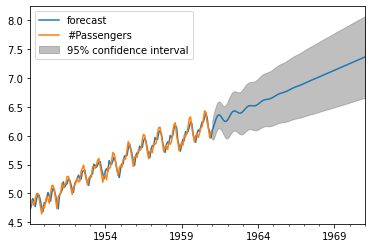

In [ ]:
results_AR.plot_predict(1,264)
results_AR.forecast(steps = 120)    # For next 12years i.e 120 months

##Observations:
The blue line is our forecasted values and the grey part is the confidence interval. So this forecasted values does not exceed the confidence interval.
* For the next 10 years our predictions are some what like this.

# **Thank You**